# Food Classification with CNN - Building a Restaurant Recommendation System

This assignment focuses on developing a deep learning-based food classification system using Convolutional Neural Networks (CNNs). You will build a model that can recognize different food categories and use it to return the food preferences of a user.

## Learning Objectives
- Implement CNNs for image classification
- Work with real-world food image datasets
- Build a preference-detector system

## Background: AI-Powered Food Preference Discovery

The system's core idea is simple:

1. Users upload 10 photos of dishes they enjoy
2. Your CNN classifies these images into the 91 categories
3. Based on these categories, the system returns the user's taste profile

Your task is to develop the core computer vision component that will power this detection engine.

You are given a training ("train" folder) and a test ("test" folder) dataset which have ~45k and ~22k samples respectively. For each one of the 91 classes there is a subdirectory containing the images of the respective class.

## Assignment Requirements

### Technical Requirements
- Implement your own pytorch CNN architecture for food image classification
- Use only the provided training dataset split for training
- Train the network from scratch ; No pretrained weights can be used
- Report test-accuracy after every epoch
- Report all hyperparameters of final model
- Use a fixed seed and do not use any CUDA-features that break reproducibility
- Use Pytorch 2.6

### Deliverables
1. Jupyter Notebook with CNN implementation, training code etc.
2. README file
3. Report (max 3 pages)

Submit your report, README and all code files as a single zip file named GROUP_[number]_NC2425_PA. The names and IDs of the group components must be mentioned in the README.
Do not include the dataset in your submission.

### Grading

1. Correct CNN implementation, training runs on the uni DSLab computers according to the README.MD instructions without ANY exceptions on the DSLab machines: 3pt
2. Perfect 1:1 reproducibility on DSLab machines: 1pt
3. Very clear github-repo-style README.MD with instructions for running the code: 1pt
4. Report: 1pt
5. Model test performance on test-set: interpolated from 30-80% test-accuracy: 0-3pt
6. Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt
7. Bonus point: use an LLM (API) to generate short description / profile of preferences of the simulated user

**If there is anything unclear about this assignment please post your question in the Brightspace discussions forum or send an email**


# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test".

In [8]:
import kagglehub
kshileeva_foodimages_nc2425_path = kagglehub.dataset_download('kshileeva/foodimages-nc2425')

print('Data source import complete.')
path = kshileeva_foodimages_nc2425_path

/vol/home/bobrovaa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


# Importing the libraries

In [9]:
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False


# Set a fixed seed for reproducibility
seed = 42
set_seed(seed)

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Defining constants

In [10]:
BATCH_SIZE = 32
EPOCHS = 70
LEARNING_RATE = 0.001
INPUT_SIZE = 256
NUM_WORKERS = 8

BEST_MODEL = "model_weights.pth"
WEIGHTS_DIR_AFTER_30 = './weights_after_20/'
TRAINING_RESULTS_FILE = "results.txt"
PROGRESS_PLOT = "progress.png"

# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test".

In [11]:
train_dir = f"{path}/train/train"
test_dir = f"{path}/test/test"

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(train_dir)
total_size = len(full_dataset)
train_size = int(0.85 * total_size)
val_size = total_size - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, train_transform)
val_dataset = TransformedDataset(val_subset, test_transform)

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

classes, class_to_idx = test_dataset.classes, test_dataset.class_to_idx
classes_num = len(classes)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Define train and test functions

In [13]:
def calculate_test_accuracy(model, dataloader, loss_fn=nn.CrossEntropyLoss(), device="cpu"):
    model.eval()

    correct_predictions, total_predictions = 0, 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)

            test_loss += loss_fn(logits, labels) * images.size(0)

            correct_predictions += (logits.argmax(dim=1) == labels).sum().item()
            total_predictions += labels.size(0)

    test_loss /= len(dataloader.dataset)
    test_accuracy = correct_predictions / total_predictions * 100
    return test_loss.item(), test_accuracy

In [14]:
def train(model, train_loader, val_loader, optimizer, criterion, device):
    val_results = []
    train_results = []

    # Track the best validation accuracy
    best_val_accuracy = 0
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Training phase
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Compute accuracy
            correct_predictions += (output.argmax(dim=1) == target).sum().item()
            total_predictions += target.size(0)

            # Loss calculation and backward pass
            loss = criterion(output, target)
            epoch_loss += loss.item() * data.size(0)
            loss.backward()

            # Update weights
            optimizer.step()

        # Calculating the average loss per sample
        epoch_loss /= len(train_loader.dataset)
        train_accuracy = correct_predictions / total_predictions * 100
        train_results.append((train_accuracy, epoch_loss))

        # Validation phase
        val_loss, val_accuracy = calculate_test_accuracy(model, val_loader, loss_fn=criterion, device=device)
        val_results.append((val_accuracy, val_loss))

        out = (
            f'Epoch [{epoch + 1}/{EPOCHS}]: \n'
            f'    Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% \n'
            f'    Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%'
        )

        print(out)

        with open(TRAINING_RESULTS_FILE, 'a') as file:
            file.write(out)
            file.write('\n')

        # Save the model weights after every epoch after the 30th one
        if epoch + 1 >= 30:
            epoch_model_path = os.path.join(WEIGHTS_DIR_AFTER_30, f'model_epoch_{epoch + 1}.pth')
            torch.save(model.state_dict(), epoch_model_path)
            print(f'Saved model at Epoch {epoch + 1}: {epoch_model_path}')

        # Save the weights with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), BEST_MODEL)

    with open(TRAINING_RESULTS_FILE, 'a') as file:
            file.write('\n')
            file.write(f'The best validation accuracy is: {best_val_accuracy:.2f}%')
            file.write('\n')

    return train_results, val_results

# CNN Implementation

In [15]:
def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=1):
    layers = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  stride=stride,
                  padding=padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        )
    return layers

In [16]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        This class represents a basic residual block. It includes a convolutional layer,
        batch normalization, and activation layers, enabling a deeper neural network by
        adding the input of the block to the output.

        Parameters
        ----------
        :param in_channels: int
            Number of input channels to the block.
        :param out_channels: int
            Number of output channels from the block.
        :param stride: int, optional
            Stride for the first convolutional layer and optional shortcut. Default is 1.
        """

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Apply downsampling if the resolution or the number of channels differ
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x):
        shortcut = self.shortcut(x)

        # First layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Output
        out += shortcut
        out = self.relu(out)
        return out

In [17]:
class FoodClassifier(nn.Module):
    """
    The convolutional neural network model used for food image classification.

    Processes input image data through multiple convolutional, residual,
    and fully connected layers, following a deep architecture inspired by ResNet.
    """

    def __init__(self, input_channels, classes_num):
        super().__init__()
        self.conv_block = nn.Sequential(
            conv_block(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.res_block1 = BasicBlock(64, 64, stride=2)
        self.res_block2 = BasicBlock(64, 128, stride=1)

        self.res_block3 = BasicBlock(128, 128, stride=1)
        self.res_block4 = BasicBlock(128, 128, stride=2)

        self.res_block5 = BasicBlock(128, 256, stride=1)
        self.res_block6 = BasicBlock(256, 256, stride=2)

        self.res_block7 = BasicBlock(256, 512, stride=1)
        self.res_block8 = BasicBlock(512, 512, stride=2)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.classifier = nn.Sequential(
             nn.Flatten(),
             nn.Linear(512 * 4 * 4, 1024),
             nn.LeakyReLU(),
             nn.Dropout(0.6),

             nn.Linear(1024, classes_num)
        )


    def forward(self, x):
        x = self.conv_block(x)  # Output: (64, 128, 128)

        x = self.res_block1(x)  # Output: (64, 64, 64)
        x = self.res_block2(x)  # Output: (128, 64, 64)

        x = self.res_block3(x)  # Output: (128, 64, 64)
        x = self.res_block4(x)  # Output: (128, 32, 32)

        x = self.res_block5(x) # Output: (256, 32, 32)
        x = self.res_block6(x) # Output: (256, 16, 16)

        x = self.res_block7(x)  # Output: (512, 16, 16)
        x = self.res_block8(x)  # Output: (512, 8, 8)

        x = self.pool(x)  # Output: (512, 4, 4)
        x = self.classifier(x)  # Output: (num_classes, 1, 1)
        return x

# Training the model
Implement your training process below. Report the test-accuracy after every epoch for the training run of the final model.

Hint: before training your model make sure to reset the seed in the training cell, as otherwise the seed may have changed due to previous training runs in the notebook

Note: If you implement automatic hyperparameter tuning, split the train set into train and validation subsets for the objective function.

In [18]:
if not os.path.exists(WEIGHTS_DIR_AFTER_30):
    os.makedirs(WEIGHTS_DIR_AFTER_30)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FoodClassifier(3, classes_num).to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4, momentum=0.8)
criterion = nn.CrossEntropyLoss()

In [13]:
train_results, valid_results = train(model, train_loader, valid_loader, optimizer, criterion, device)

Epoch [1/70]: 
    Train Loss: 4.3571 | Train Acc: 3.87% 
    Val Loss: 4.1246 | Val Acc: 6.90%
Epoch [2/70]: 
    Train Loss: 4.0146 | Train Acc: 8.60% 
    Val Loss: 3.7934 | Val Acc: 12.51%
Epoch [3/70]: 
    Train Loss: 3.7736 | Train Acc: 12.29% 
    Val Loss: 3.5849 | Val Acc: 15.16%
Epoch [4/70]: 
    Train Loss: 3.5710 | Train Acc: 15.64% 
    Val Loss: 3.5767 | Val Acc: 16.02%
Epoch [5/70]: 
    Train Loss: 3.3804 | Train Acc: 19.11% 
    Val Loss: 3.3152 | Val Acc: 20.89%
Epoch [6/70]: 
    Train Loss: 3.2038 | Train Acc: 22.25% 
    Val Loss: 3.1071 | Val Acc: 24.61%
Epoch [7/70]: 
    Train Loss: 3.0330 | Train Acc: 25.66% 
    Val Loss: 2.9707 | Val Acc: 26.76%
Epoch [8/70]: 
    Train Loss: 2.8824 | Train Acc: 28.79% 
    Val Loss: 2.8260 | Val Acc: 29.97%
Epoch [9/70]: 
    Train Loss: 2.7512 | Train Acc: 31.25% 
    Val Loss: 2.7568 | Val Acc: 32.01%
Epoch [10/70]: 
    Train Loss: 2.6217 | Train Acc: 33.96% 
    Val Loss: 2.5742 | Val Acc: 35.61%
Epoch [11/70]: 
    Tr

In [15]:
def progress_plot(train_results, valid_results):
    valid_accuracies, valid_losses = zip(*valid_results)
    train_accuracies, train_losses = zip(*train_results)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax1.plot(valid_accuracies, label='Validation Accuracy', color='blue')
    ax2.plot(valid_losses, label='Validation Loss', color='blue')

    ax1.plot(train_accuracies, label='Train Accuracy', color='orange')
    ax2.plot(train_losses, label='Train Loss', color='orange')

    ax1.set_xlabel("Epoch")
    ax1.set_title("Training Progress")
    ax1.legend()

    ax2.set_xlabel("Epoch")
    ax2.set_title("Training Progress")
    ax2.legend()
    fig.savefig(PROGRESS_PLOT)

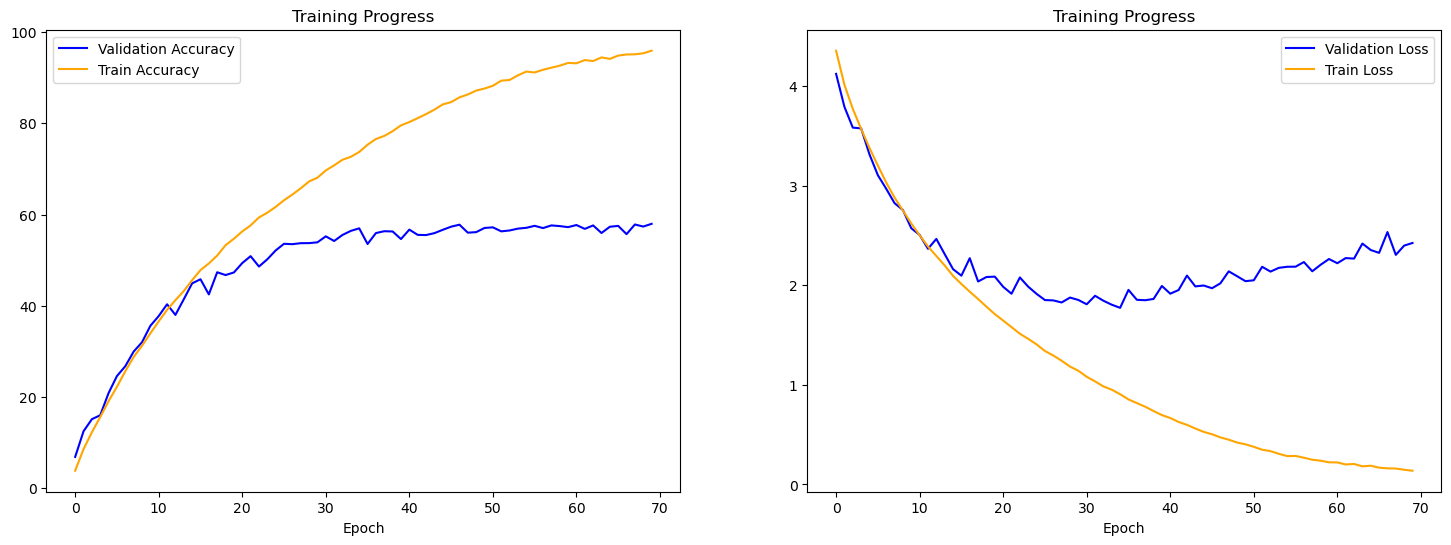

In [16]:
progress_plot(train_results, valid_results)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FoodClassifier(3, classes_num).to(device)

# If the model was not trained from the previous cell then use the code below
epoch = 46
model.load_state_dict(torch.load(f'model_epoch_{epoch}.pth', weights_only=True))

# If the model is trained from the previous cell, then run this line instead:
# model.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR_AFTER_30, f'model_epoch_{46}.pth'), weights_only=True))

criterion = nn.CrossEntropyLoss()

loss, accuracy = calculate_test_accuracy(model, test_loader, criterion, device)

out = f'Test Accuracy: {accuracy}, Loss: {loss}'
print(out)
with open(TRAINING_RESULTS_FILE, 'a') as file:
    file.write(out)
    file.write('\n')

Test Accuracy: 57.208187186431644, Loss: 1.9589732885360718


# Simulation of random user
Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt

In [33]:
from collections import Counter

In [34]:
# Function to sample 10 images from test set with a given seed
def get_random_images(dataset, seed=42, num_samples=10):
    random.seed(seed)
    indices = random.sample(range(len(dataset)), num_samples)
    return [dataset[i] for i in indices]

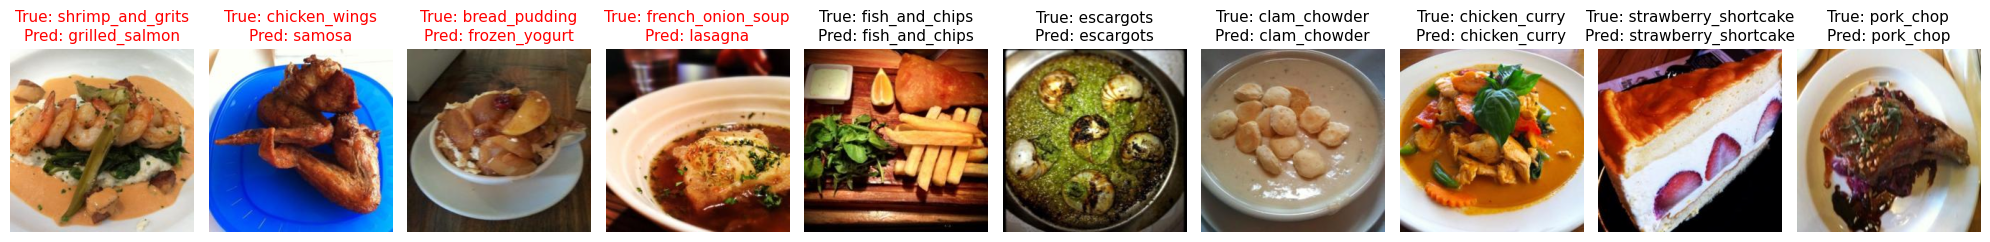

Predicted Class Frequencies: {'grilled_salmon': 1, 'samosa': 1, 'frozen_yogurt': 1, 'lasagna': 1, 'fish_and_chips': 1, 'escargots': 1, 'clam_chowder': 1, 'chicken_curry': 1, 'strawberry_shortcake': 1, 'pork_chop': 1}
True Class Frequencies: {'shrimp_and_grits': 1, 'chicken_wings': 1, 'bread_pudding': 1, 'french_onion_soup': 1, 'fish_and_chips': 1, 'escargots': 1, 'clam_chowder': 1, 'chicken_curry': 1, 'strawberry_shortcake': 1, 'pork_chop': 1}


In [35]:
# Sample 10 random images from the test dataset
num_samples = 10
simulation_seed = 42
sampled_images = get_random_images(test_dataset, seed=simulation_seed, num_samples=num_samples)

# Separate images and true labels
images_tensor = torch.stack([img for img, _ in sampled_images]).to(device)
true_labels = [label for _, label in sampled_images]
true_classes = [classes[i] for i in true_labels]

# Run model predictions
model.eval()
with torch.no_grad():
    outputs = model(images_tensor)
    predicted_indices = torch.argmax(outputs, dim=1).cpu().tolist()
    predicted_classes = [classes[i] for i in predicted_indices]

# Plotting the 10 test images with the true and predicted labels
plt.figure(figsize=(20, 5))
for i in range(num_samples):
    img = sampled_images[i][0].permute(1, 2, 0).cpu().numpy()
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    if predicted_classes[i] == true_classes[i]:
        title_color = "black"  # Correct predictions in black
    else:
        title_color = "red"  # Incorrect predictions in red


    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_classes[i]}\nPred: {predicted_classes[i]}",
              color=title_color,
              fontsize=11)
    
plt.tight_layout()
plt.show()
    
# frequency count
predicted_freq = Counter(predicted_classes)
true_freq = Counter(true_classes)

print("Predicted Class Frequencies:", dict(predicted_freq))
print("True Class Frequencies:", dict(true_freq))

# Bonus point

In [26]:
import requests

prompt = (
    "Given the following list of foods that a user enjoys:\n\n"
    + ", ".join(predicted_classes) +
    "\n\nWrite a short paragraph describing the user's food preferences."
)

API_URL = "https://api-inference.huggingface.co/models/mistralai/Mixtral-8x7B-Instruct-v0.1"
headers = {
    "Authorization": "...",
    "Content-Type": "application/json"
}

response = requests.post(API_URL, headers=headers, json={"inputs": prompt})

if response.status_code == 200:
    full_text = response.json()[0]['generated_text']

    # removes the echoed prompt from the output
    if prompt in full_text:
        output_only = full_text.split(prompt)[-1].strip()
    else:
        output_only = full_text.strip()

    print("\nLLM response (user's food preference profile):\n")
    print(output_only)
else:
    print("API call failed:", response.status_code)
    print(response.text)


LLM response (user's food preference profile):

Based on the given list, the user appears to enjoy a variety of foods from different cuisines. They seem to have a fondness for savory dishes, as indicated by their preference for grilled salmon, chicken wings, pork chop, and chicken curry. The user also appears to enjoy international flavors, as evidenced by their choices of nachos, escargots, and clam chowder. Additionally, the user has a sweet tooth, as they have included cheesecake in their list of favorites. However, it's interesting to note that they have included pork chop twice, which suggests that it might be one of their all-time favorite dishes. Overall, the user's food preferences indicate that they have a diverse palate and enjoy both meat-based and dairy-based dishes.
